In [1]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
import sys
import warnings
warnings.filterwarnings('ignore')

dir_package = "../"
# dir_package = "/users/rpilon/codes/unil/CloudBandDetection/"
sys.path.insert(0, dir_package + "src")
from tracking import plot_tracking_on_map
from io_utilities import load_ymlfile, load_data_from_saved_var_files
from time_utilities import create_list_of_dates


#### Load configuration file and make adjustements for this test case

In [2]:
# config_file = "../config/config_analysis.yml"
config_file = dir_package + "config/config_analysis.yml"
config = load_ymlfile(config_file, isconfigfile=True)
# Make sure that the period for the cloud bands cover the same period as the example data
config["startdate"] = "20210219.00"
config["enddate"] = "20210228.00"
# config["saved_dirpath"] = "../data/"
config["saved_dirpath"] = dir_package + "data/"

print(config)

{'domain': 'southPacific', 'startdate': '20210219.00', 'enddate': '20210228.00', 'saved_dirpath': '../data/', 'dir_figures': './cloud_band_figures/', 'flag_use_saveddailyvar': True, 'select_djfm': False, 'hemisphere': 'south', 'lon_west': 130, 'lon_east': 290, 'lat_north': 5, 'lat_south': -50}


#### Load cloud bands from the South Pacific: a full year is loaded (we will need to subset)

In [5]:
listofdates = create_list_of_dates(config)
list_of_cloud_bands = load_data_from_saved_var_files(config, varname="list_of_cloud_bands")

#### Import longitudes and latitudes for the map

In [13]:
lats_globe = np.load(dir_package + "data/lats_globe0.5_ERA5.npy")
lons_globe = np.load(dir_package + "data/lons_globe0.5_ERA5.npy")
# Get longitudes and latitudes of South Pacific domain
lon_ids = [id for id, el in enumerate(lons_globe) if el <= config["lon_east"] if el >= config["lon_west"]]
lonsSP = lons_globe[lon_ids]
lat_ids = [id for id, el in enumerate(lats_globe) if el <= config["lat_north"] if el >= config["lat_south"]]
latsSP = lats_globe[lat_ids]
print(f"Longitudes, min: {lonsSP.min()}, max: {lonsSP.max()}")
print(f"Latitudes, min: {latsSP.min()}, max: {latsSP.max()}")

Longitudes, min: 130.0, max: 290.0
Latitudes, min: -50.0, max: 5.0


In [17]:
# Get indices of times to subset the period chosen in the config file
itime_start = [i for i, el in enumerate(listofdates) if el.strftime("%Y%m%d.00")==config["startdate"]][0]
itime_end = [i for i, el in enumerate(listofdates) if el.strftime("%Y%m%d.00")==config["enddate"]][0]+1
# Subset
sub_listofdates = listofdates[itime_start:itime_end]
sub_list_of_cloud_bands = list_of_cloud_bands[itime_start:itime_end]
print(sub_list_of_cloud_bands[-1])


[<entities.CloudBand object at 0x1645c9790>, <entities.CloudBand object at 0x1645c9490>]


#### Create the series of map with connection lines between the centroid lcoation of each cloud bands

AttributeError: 'NoneType' object has no attribute 'latloncenter'

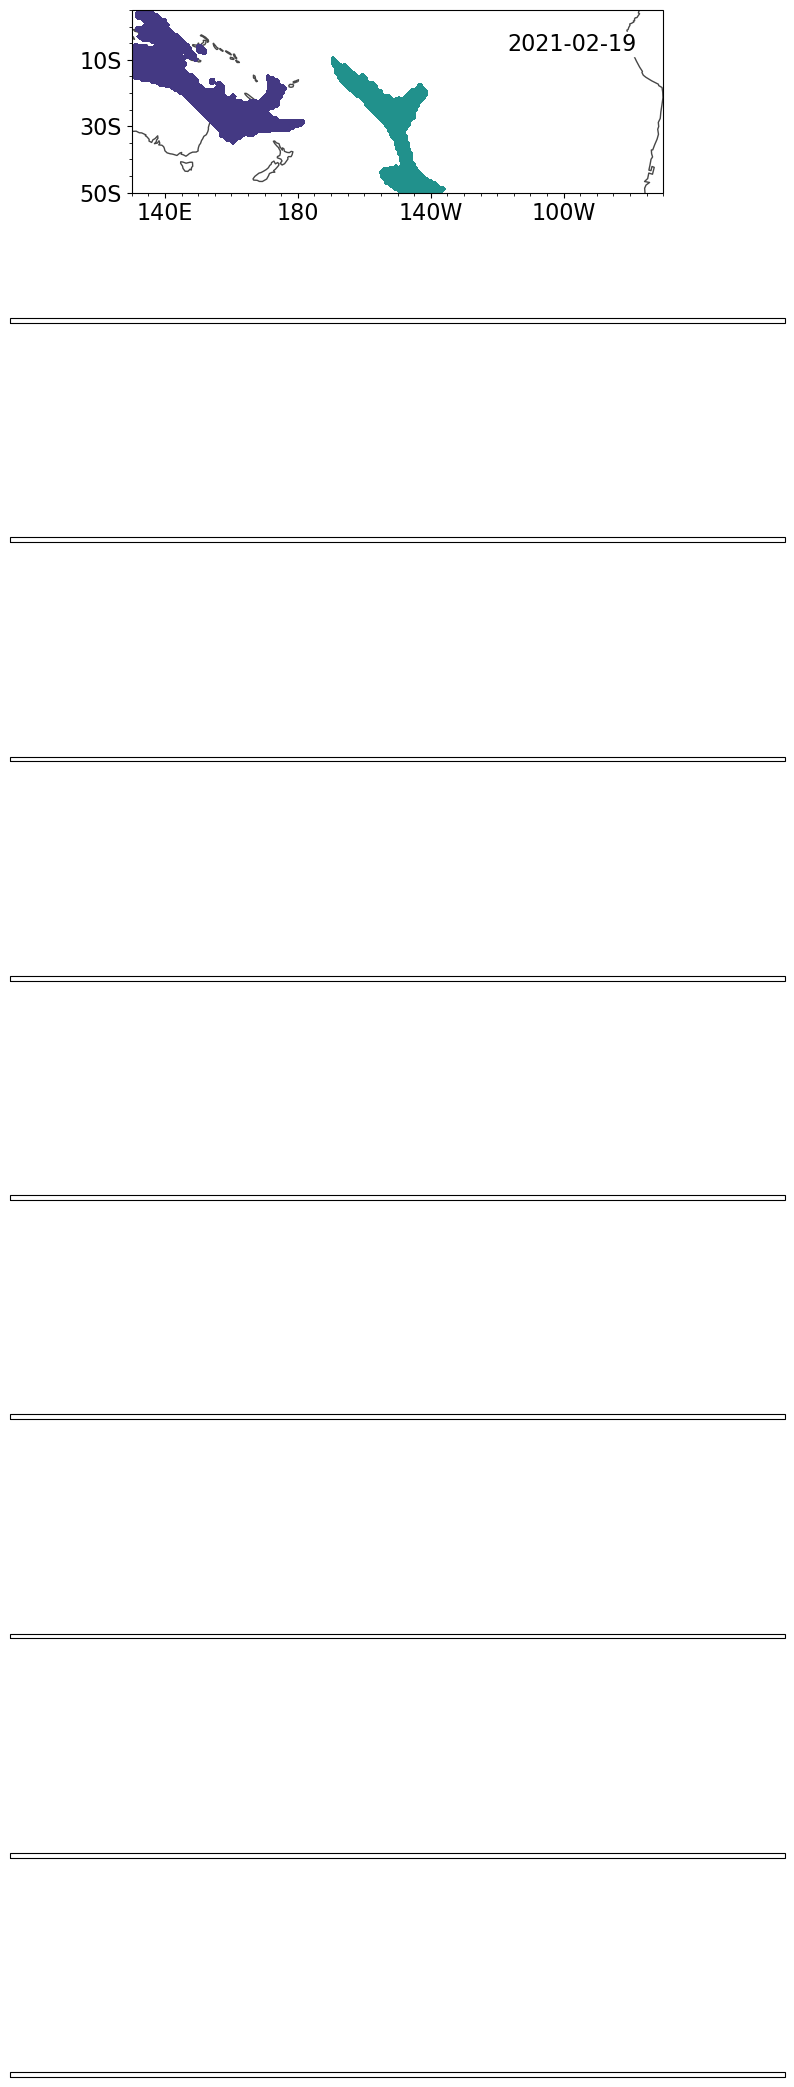

In [15]:
plot_tracking_on_map(
    list_of_cloud_bands=sub_list_of_cloud_bands,
    lons=lonsSP,
    lats=latsSP,
    listofdates=sub_listofdates,
    config=config,
    show=True,
    save=False,
)